# NLP:  Create a model for moderating comments in the test set


Model will use the approved and rejected category to classify the code cases 

A BiDirectional LSM model is used to model


## Import packages

In [1]:
# pip install nlp
import csv
import nlp
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf 
import matplotlib.pyplot as plt
import os 

# Import Original data 

In [2]:
#______________Loading the data
#news_dataset = nlp.load_dataset('civil_comments')
os.chdir(r'C:\Users\EmileVDH\civil_comments')
raw_data = pd.read_csv('train.csv') #,nrows=10
#test_data = pd.read_csv('test.csv')

## Explore Original data set 

In [3]:
raw_data['rating'].value_counts()

approved    1684758
rejected     120116
Name: rating, dtype: int64

In [7]:
raw_data['rating'].value_counts(normalize=True)

approved    0.933449
rejected    0.066551
Name: rating, dtype: float64

In [4]:
raw_data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
raw_data.loc[11]  #ACCEPT examples

id                                                                                239579
target                                                                              0.44
comment_text                           This is a great story. Man. I wonder if the pe...
severe_toxicity                                                                        0
obscene                                                                         0.293333
identity_attack                                                                        0
insult                                                                              0.32
threat                                                                                 0
asian                                                                                  0
atheist                                                                                0
bisexual                                                                               0
black                

In [6]:
raw_data.loc[4]  #REJECT example

id                                                                    59856
target                                                             0.893617
comment_text                           haha you guys are a bunch of losers.
severe_toxicity                                                   0.0212766
obscene                                                                   0
identity_attack                                                   0.0212766
insult                                                              0.87234
threat                                                                    0
asian                                                                     0
atheist                                                                   0
bisexual                                                                  0
black                                                                     0
buddhist                                                                  0
christian   

# Look at word Count 

In [9]:
raw_data['WordCount']=raw_data['comment_text'].str.split().str.len()

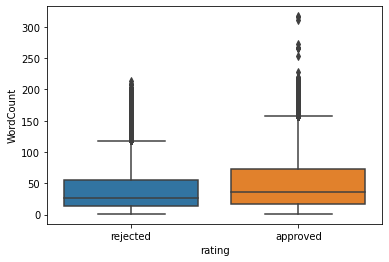

In [10]:
sns.boxplot(x='rating', y='WordCount', data=raw_data); #STOP WORDS REMOVED

# Create smaller Balanced DataSet

In [13]:
df_small_0=raw_data[raw_data['rating']=='rejected'].sample(n=25000,random_state=42 )
df_small_1=raw_data[raw_data['rating']=='approved'].sample(n=25000,random_state=42 )
df_small = pd.concat([df_small_1, df_small_0])
df_small.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,WordCount
904345,5226233,0.2,I do not think it would be a crime to send in ...,0.1,0.0,0.1,0.2,0.2,NaN,NaN,...,approved,0,0,1,1,0,0.0,0,10,43
842881,5152140,0.0,"Maybe we can get the facts regarding boneless,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,approved,0,0,0,1,0,0.0,4,4,18
460202,808455,0.0,A progressive tax on income taxes more as inco...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,1,0,0,0,0,0.0,0,4,120
1040937,5389583,0.0,"TDW,\n\nI completely agree with you. People r...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,approved,1,0,0,0,0,0.0,4,4,13
1322985,5732084,0.0,almost true except that 49% of the vote went t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,approved,0,0,0,2,0,0.0,4,4,58


In [15]:
print(df_small['rating'].value_counts())
print(df_small['rating'].value_counts(normalize=True))

rejected    25000
approved    25000
Name: rating, dtype: int64
rejected    0.5
approved    0.5
Name: rating, dtype: float64


# Removing characters

In [17]:
import re

def clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return df

df_small= clean_text(df_small, "comment_text", "text_clean")
df_small['text_clean'].head()

904345     i do not think it would be a crime to send in ...
842881     maybe we can get the facts regarding boneless ...
460202     a progressive tax on income taxes more as inco...
1040937    tdwi  completely agree with you people really ...
1322985    almost true except that  of the vote went to b...
Name: text_clean, dtype: object

# Remove Stop Words

In [18]:
stop = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
df_small['text_clean'] = df_small['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_small['text_clean'].head()

904345     not think crime send drone equipped moab remov...
842881     maybe can get facts regarding boneless skinles...
460202     progressive tax income taxes income rises regr...
1040937    tdwi completely agree people really buy regula...
1322985    almost true except vote went bernier offering ...
Name: text_clean, dtype: object

# Use rating as a binary classifier to reject or accept called Reject 

In [19]:
df_small = df_small[['rating','text_clean']]

In [20]:
df_small['Rejected'] = df_small['rating'].map({'rejected':1, 'approved':0})

# Create Training and Validation and Test Set 

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.6, frac_val=0.15, frac_test=0.25,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

In [22]:
df_train, df_val, df_test = split_stratified_into_train_val_test(df_small, stratify_colname='Rejected', frac_train=0.60, frac_val=0.20, frac_test=0.20)

In [24]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(30000, 3)
(10000, 3)
(10000, 3)


In [26]:
print(df_train['rating'].value_counts(normalize=True))
print(df_val['rating'].value_counts(normalize=True))
print(df_test['rating'].value_counts(normalize=True))

rejected    0.5
approved    0.5
Name: rating, dtype: float64
rejected    0.5
approved    0.5
Name: rating, dtype: float64
rejected    0.5
approved    0.5
Name: rating, dtype: float64


# Split into a INPUTS AND TARGET SET 

In [27]:
X_train=df_train['text_clean']
X_val=df_val['text_clean']
X_test=df_test['text_clean']

y_train=df_train['rating']
y_val=df_val['rating']
y_test=df_test['rating']


# HyperParamaters

In [28]:
vocab_size =5000       ## How many of top words used in model all others will be made unknown 
embedding_dim = 16
max_length = 120       ##Limit the number of words coded to 120 
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

 # Tokenise X ..Comments

In [29]:
tokenizer = Tokenizer( num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(word_index)

{'<OOV>': 1, 'not': 2, 'will': 3, 'no': 4, 'people': 5, 'like': 6, 'just': 7, 'one': 8, 'can': 9, 'trump': 10, 'dont': 11, 'get': 12, 'us': 13, 'time': 14, 'now': 15, 'know': 16, 'think': 17, 'good': 18, 'even': 19, 'many': 20, 'right': 21, 'see': 22, 'make': 23, 'go': 24, 'much': 25, 'years': 26, 'way': 27, 'need': 28, 'well': 29, 'want': 30, 'money': 31, 'never': 32, 'government': 33, 'canada': 34, 'going': 35, 'say': 36, 'also': 37, 'back': 38, 'really': 39, 'take': 40, 'im': 41, 'state': 42, 'country': 43, 'thats': 44, 'nothing': 45, 'tax': 46, 'every': 47, 'another': 48, 'world': 49, 'first': 50, 'work': 51, 'cant': 52, 'said': 53, 'white': 54, 'still': 55, 'pay': 56, 'new': 57, 'better': 58, 'doesnt': 59, 'youre': 60, 'left': 61, 'off': 62, 'president': 63, 'public': 64, 'women': 65, 'made': 66, 'may': 67, 'real': 68, 'something': 69, 'believe': 70, 'anything': 71, 'didnt': 72, 'little': 73, 'thing': 74, 'use': 75, 'care': 76, 'sure': 77, 'free': 78, 'day': 79, 'news': 80, 'year'

In [30]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [32]:
validation_sequences = tokenizer.texts_to_sequences(X_val)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [33]:
training_padded = np.array(train_padded)
validation_padded = np.array(validation_padded)

In [34]:
pd.set_option('display.max_colwidth', -1)

C:\Users\EmileVDH\AppData\Local\Continuum\anaconda3\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [39]:
X_train.iloc[7]

'maybe canadians consider taking retirement collection commish just wouldnt go awaymakes happy not living canadian city nhl team'

In [41]:
train_sequences[7]

[102,
 180,
 563,
 319,
 1288,
 4288,
 1,
 7,
 313,
 24,
 1,
 554,
 2,
 286,
 112,
 207,
 3749,
 493]

In [42]:
train_padded[7]

array([ 102,  180,  563,  319, 1288, 4288,    1,    7,  313,   24,    1,
        554,    2,  286,  112,  207, 3749,  493,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

# Token Y on reject label 

In [43]:
label_tokenizer = Tokenizer()  #simple case no paramaters needed 
label_tokenizer.fit_on_texts(y_train)
label_word_index = label_tokenizer.word_index
label_seq = label_tokenizer.texts_to_sequences(y_train)

training_labels = np.array(label_tokenizer.texts_to_sequences(y_train))
validation_labels = np.array(label_tokenizer.texts_to_sequences(y_val))
print(label_word_index)

training_labels=np.where(training_labels==2,0,1)
validation_labels=np.where(validation_labels==2,0,1)
print(training_labels)
print(validation_labels)

{'rejected': 1, 'approved': 2}
[[1]
 [1]
 [0]
 ...
 [1]
 [0]
 [0]]
[[1]
 [0]
 [1]
 ...
 [1]
 [1]
 [1]]


CHECK

In [44]:
training_labels.shape

(30000, 1)

In [45]:
len(training_padded)

30000

In [46]:
validation_labels.shape

(10000, 1)

In [47]:
len(validation_padded)

10000

# MODEL AND TRANING 

### Model 1 BIDIRECTIONAL LSTM  (Selected model)

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           80000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 94,129
Trainable params: 94,129
Non-trainable params: 0
_________________________________________________________________


In [49]:
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=1)

Train on 30000 samples, validate on 10000 samples
Epoch 1/10
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.6400 - accuracy: 0.6226 - val_loss: 0.6150 - val_accuracy: 0.6585
Epoch 2/10
30000/30000 [==============================] - 36s 1ms/sample - loss: 0.5698 - accuracy: 0.7042 - val_loss: 0.6175 - val_accuracy: 0.6603
Epoch 3/10
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.5356 - accuracy: 0.7293 - val_loss: 0.6273 - val_accuracy: 0.6544
Epoch 4/10
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.4964 - accuracy: 0.7568 - val_loss: 0.6697 - val_accuracy: 0.6471
Epoch 5/10
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.4605 - accuracy: 0.7772 - val_loss: 0.7134 - val_accuracy: 0.6386
Epoch 6/10
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.4292 - accuracy: 0.7973 - val_loss: 0.7823 - val_accuracy: 0.6316
Epoch 7/10
30000/30000 [==============================] 

### MODEL 2 GRU 

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=1)

### Model 3 Most basic NN model 

In [ ]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

history = model.fit(training_padded, training_labels,
                    epochs=5,
                    verbose=True,
                    validation_data=(validation_padded, validation_labels),
                    batch_size=10)

### Vader Model Tool  (FOR COMPARISON ONLY)

In [ ]:
pip install vaderSentiment

In [ ]:
# import SentimentIntensityAnalyzer class 
# from vaderSentiment.vaderSentiment module. 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
  
# function to print sentiments 
# of the sentence. 
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
      
    print("Overall sentiment dictionary is : ", sentiment_dict) 
    print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
    print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
    print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 
  
    print("Sentence Overall Rated As", end = " ") 
  
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05 : 
        print("Positive") 
  
    elif sentiment_dict['compound'] <= - 0.05 : 
        print("Negative") 
  
    else : 
        print("Neutral") 

In [ ]:
    sentence = """ this is america"""
  
    sentiment_scores(sentence)

# Assesment

### Graph : When was the best epoh to stop training 

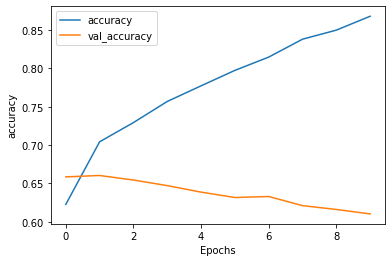

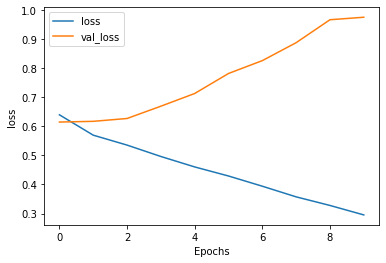

In [52]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, 'loss')

In [ ]:
##### Overfitting very apparent 

### Score training and Validation sets

In [130]:
estimates_Training=model.predict_classes(training_padded, verbose=0) 
p_Training=model.predict_proba(training_padded).max(axis=1) 
print(model.predict(training_padded))
print(estimates_Training)

[[0.85711414]
 [0.61019015]
 [0.2220144 ]
 ...
 [0.83756167]
 [0.03971327]
 [0.18098778]]
[[1]
 [1]
 [0]
 ...
 [1]
 [0]
 [0]]


In [125]:
estimates_Validation=model.predict_classes(validation_padded, verbose=0) 
p_Validation=model.predict_proba(validation_padded).max(axis=1) 
print(model.predict(validation_padded))
print(estimates_Validation)

[[0.24719165]
 [0.14415383]
 [0.9565308 ]
 ...
 [0.7877531 ]
 [0.57655877]
 [0.8395413 ]]
[[0]
 [0]
 [1]
 ...
 [1]
 [1]
 [1]]


### Scoring Test Data Set 

#######  X_test y_test are unseen to the model , and need to be tokenised 

In [63]:
test_X = tokenizer.texts_to_sequences(X_test)
padded_test_X = pad_sequences(test_X, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [126]:
estimates_Test=model.predict_classes(padded_test_X , verbose=0)
p_Test=model.predict_proba(padded_test_X).max(axis=1) 

In [74]:
label_tokenizer.fit_on_texts(y_test)
label_word_index = label_tokenizer.word_index
label_seq = label_tokenizer.texts_to_sequences(y_test)
testing_labels = np.array(label_tokenizer.texts_to_sequences(y_test))
testing_labels=np.where(testing_labels==2,0,1)

## Conf Matrix 

In [58]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [59]:
####Training 
actual = training_labels
predicted = estimates_Training
results = confusion_matrix(actual, predicted) 
  
print(results)
print(accuracy_score(actual, predicted))
print(classification_report(actual, predicted))

[[13305  1695]
 [ 1084 13916]]
0.9073666666666667
              precision    recall  f1-score   support

           0       0.92      0.89      0.91     15000
           1       0.89      0.93      0.91     15000

    accuracy                           0.91     30000
   macro avg       0.91      0.91      0.91     30000
weighted avg       0.91      0.91      0.91     30000



In [60]:
#Validation 

actual = validation_labels
predicted = estimates_Validation
results = confusion_matrix(actual, predicted) 
  
print(results)
print(accuracy_score(actual, predicted))
print(classification_report(actual, predicted))

[[2980 2020]
 [1878 3122]]
0.6102
              precision    recall  f1-score   support

           0       0.61      0.60      0.60      5000
           1       0.61      0.62      0.62      5000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



In [76]:
#Test 
actual = testing_labels
predicted = estimates_Test
results = confusion_matrix(actual, predicted) 
  
print(results)
print(accuracy_score(actual, predicted))
print(classification_report(actual, predicted))

[[3033 1967]
 [1835 3165]]
0.6198
              precision    recall  f1-score   support

           0       0.62      0.61      0.61      5000
           1       0.62      0.63      0.62      5000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000



In [ ]:
#Distribution of Probabilities 

In [131]:
print(p_Training.mean())
print(p_Validation.mean())
print(p_Test.mean())

0.4963397
0.4956008
0.49170497


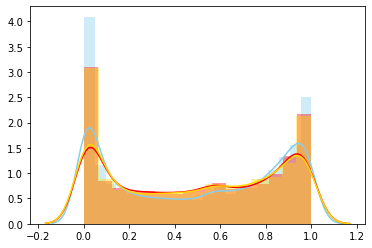

In [134]:
sns.distplot( p_Training , color="skyblue", label="Train")
sns.distplot( p_Validation , color="red", label="Validation")
sns.distplot( p_Test , color="gold", label="Test")


### Save/Load this Model Weights and Arcitecture

In [83]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('NLP_Comments_Classification_20200531.h5') 

In [84]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('NLP_Comments_Classification_20200531.h5')

# Show the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           80000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 94,129
Trainable params: 94,129
Non-trainable params: 0
_________________________________________________________________


### Save/Load the Tokenisers

In [78]:
import pickle

In [80]:
# saving
with open('tokenizer_X_20200531.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('tokenizer_Y_20200531.pickle', 'wb') as handle:
    pickle.dump(label_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [82]:
# loading
with open('tokenizer_X_20200531.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

with open('tokenizer_Y_20200531.pickle', 'rb') as handle:
    label_tokenizer = pickle.load(handle)

# Scoring random words 

In [85]:
category_codes = {
    'rejected': 0,
    'approved': 1,

}

In [86]:
def get_category_name(category_id):
    for category, id_ in category_codes.items():    
        if id_ == category_id:
            return category

In [ ]:
##Some word ideas
print(word_index)

In [87]:
sentence = ["""This was very shit post , terrible"""]

In [88]:
x = tokenizer.texts_to_sequences(sentence)
#word_index = tokenizer.word_index
print(x)
paddedx = pad_sequences(x, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(paddedx)

[[1, 1, 1, 2393, 148, 1740]]
[[   1    1    1 2393  148 1740    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


In [89]:
print(get_category_name(model.predict_classes(paddedx, verbose=0)))
print(model.predict_classes(paddedx, verbose=0))
print(model.predict_proba(paddedx).max(axis=1) )
print(model.predict_proba(paddedx))

approved
[[1]]
[0.7966074]
[[0.7966074]]


In [90]:
#sentence = ["""excellent work"""]
sentence = [r"excellent work man"]
x = tokenizer.texts_to_sequences(sentence)
paddedx = pad_sequences(x, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(get_category_name(model.predict_classes(paddedx, verbose=0)))
print(model.predict_proba(paddedx).max(axis=1) )
print(x)

rejected
[0.28962636]
[[1053, 51, 86]]


### Create Function to score Any list 

In [91]:
 # Creating an empty Dataframe with column names only
df = pd.DataFrame(columns=['TEXT'])
df = df.append({'TEXT': 'textbodyvv'}, ignore_index=True)

In [113]:
def modelevdh(textbody) : 
        phrase=list([textbody])
        x = tokenizer.texts_to_sequences(phrase)
        paddedx = pad_sequences(x, maxlen=max_length, padding=padding_type, truncating=trunc_type)
        suggestion = get_category_name(model.predict_classes(paddedx, verbose=0))
        probability=model.predict_proba(paddedx).max(axis=1) 
        print(phrase)
        if probability==0:
            print("No Classification")
        elif probability<=.3:
            print("Accepted")
        elif probability>=.7:
            print("Reject")
        else:
            print("Neutral")
        print(probability)     

In [114]:
modelevdh('excellent work man') 

['excellent work man']
Accepted
[0.28962636]


In [117]:
modelevdh("would love to know how Dlamini qualified for this position(nepotism aside) . She isn't fit to be a housemaid!") 

["would love to know how Dlamini qualified for this position(nepotism aside) . She isn't fit to be a housemaid!"]
Reject
[0.9473101]


In [121]:
modelevdh('Integrity means that you pay your debts.]\n\nDoes this apply to President Trump too?')

['Integrity means that you pay your debts.]\n\nDoes this apply to President Trump too?']
Neutral
[0.60939974]


### Using function to score a list eg text excel sheet 

In [118]:
test_data = pd.read_csv('test.csv')

In [119]:
test_data.head(100)

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\nDoes this apply to President Trump too?
1,7097321,This is malfeasance by the Administrator and the Board. They are wasting our money!
2,7097322,"@Rmiller101 - Spoken like a true elitist. But look out bud. The re-awakening in Europe, Brexit and now the Trump victory are just the beginning. The unwashed masses are coming for you and your ilk…."
3,7097323,"Paul: Thank you for your kind words. I do, indeed, have strong beliefs and don't hide them. They are based on both facts and values. I think the question of ""bias"" and ""prejudice"" comes into play when we're discussing beliefs and attitudes based on values. One of our poster friends, for example, often comments that being ""intolerant"" of a bias, for example, is, in itself, a bias. This is, IMO, where the concept of ""irratonal antipathy"" is important. If I dislike neo-Nazis because of their views on race, my antipathy is based on fact (knowledge of their views) and values (my belief that condemning others because of their race/religion is WRONG). Were I to, instead, dislike all Germans, that, IMO, would represent a bias...an irrational antipathy...since not all Germans condemn others because of their race/religion. I discuss the ""bias"" question in another response to you....\n\nIt's an interesting topic and I'd enjoy discussing it w/you sometime. Give me a call. Gary Crum"
4,7097324,Sorry you missed high school. Eisenhower sent troops to Vietnam after the French withdrew in 1954 and before that America was providing 50% of the cost of that war. WWI & WWII were won by Democrat Presidents and the last win a Republican had was 1865 but the did surrender in Korea and Vietnam and fail to win in desert Storm or these two wars.
...,...,...
95,7097415,I would love to know how Dlamini qualified for this position(nepotism aside) . She isn't fit to be a housemaid!
96,7097416,"The Three Stooges -- Trump, Nunes, Ryan!"
97,7097417,Just select 'hide replies' on the top. G&M had already acted on it. Good.
98,7097418,"I don't know why this subject has been inflated to a cultural issue. it's really more simple: Eat less and exercise more! Take responsibility for your own personal dietary decisions. Don't blame society, the missionaries, and the Foreigners. I mua!"


In [ ]:
test=test_data['comment_text'].head(100)

In [ ]:
assesment=list()

for i in test:
    assesment.append(modelevdh(i))
    

In [ ]:
assess = pd.DataFrame(assesment)

In [ ]:
print(assess.value_counts())
print(assess.value_counts(normalize=True))

In [ ]:
test_set=pd.merge(test_data ,assesment)

In [ ]:
test_set.head(100)